In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os

# --- 추천 코드 결합 시작 ---

# 1. 경로 변수화 및 압축 해제 준비
# ※※※ 본인 환경에 맞게 파일명을 확인해주세요 ※※※
BASE_DRIVE_PATH = '/content/drive/MyDrive/인공지능 튜플'
ZIP_FILE_NAME = 'OriginalDataset.zip' # <- 실제 ZIP 파일명
UNZIPPED_FOLDER_NAME = 'OriginalDataset' # <- 압축 해제 후 생성되는 폴더명

zip_path = os.path.join(BASE_DRIVE_PATH, ZIP_FILE_NAME)
extract_path = f'/content/{UNZIPPED_FOLDER_NAME}'

# 2. Colab 환경에 압축 풀기 (학습 속도 향상)
print("압축 해제를 시작합니다...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/') # /content/ 경로에 압축을 풉니다.
print(f"압축 해제 완료! 데이터가 '{extract_path}'에 준비되었습니다.")

# --- 추천 코드 결합 끝 ---


# 1. 기본 설정 및 데이터 경로 지정
# !!! 중요: 데이터 경로는 압축이 풀린 로컬 경로를 사용합니다 !!!
DATA_DIR = extract_path
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4 # MildDemented, ModerateDemented, NonDemented, VeryMildDemented

# 2. 데이터 로드 및 분할
# Keras 유틸리티를 사용하여 데이터셋 생성
full_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123,
    validation_split=0.2, # 훈련/검증 데이터 80:20으로 분할
    subset='both'
)

train_dataset, val_dataset = full_dataset

class_names = train_dataset.class_names
print(f"클래스: {class_names}")

# 데이터셋 성능 최적화
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

# 3. ViT를 위한 구성요소 정의
# MLP (Feed-Forward Network)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Transformer Encoder 블록
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.1)
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation=tf.nn.gelu),
            layers.Dense(embed_dim),
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        attention_output = self.attention(inputs, inputs)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

# 4. CNN-ViT 하이브리드 모델 빌드 함수
def build_cnn_vit_model(input_shape, num_classes):
    # 입력 레이어
    inputs = layers.Input(shape=input_shape)

    # 데이터 증강 레이어
    augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ], name="augmentation")
    x = augmentation(inputs)

    # Part 1: CNN Backbone (EfficientNetV2B0)
    cnn_backbone = keras.applications.efficientnet_v2.EfficientNetV2B0(
        include_top=False,
        weights="imagenet",
        input_tensor=x
    )
    cnn_backbone.trainable = True # Fine-tuning을 위해 훈련 가능하게 설정
    print(f"CNN Backbone 출력 Shape: {cnn_backbone.output.shape}")

    # Part 2: CNN과 ViT 연결
    x = cnn_backbone.output
    reshaped = layers.Reshape((-1, x.shape[-1]))(x)
    print(f"Reshape 이후 Shape: {reshaped.shape}")

    # Part 3: ViT Encoder
    # Positional Embedding 추가
    positions = tf.range(start=0, limit=reshaped.shape[1], delta=1)
    pos_embedding = layers.Embedding(input_dim=reshaped.shape[1], output_dim=x.shape[-1])(positions)
    x = reshaped + pos_embedding

    # Transformer Encoder 블록 쌓기
    for _ in range(4): # 4개의 Transformer 블록 사용
        x = TransformerEncoder(embed_dim=x.shape[-1], dense_dim=1024, num_heads=4)(x)

    # Part 4: 최종 분류기
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # 최종 모델 생성
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# 5. 모델 생성, 컴파일 및 학습
# 모델 빌드
model = build_cnn_vit_model(input_shape=IMG_SIZE + (3,), num_classes=NUM_CLASSES)

# 모델 컴파일
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# 모델 학습
epochs = 20
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

# 6. 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

압축 해제를 시작합니다...


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/인공지능 튜플/OriginalDataset.zip'

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# 1) Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 데이터 경로 설정
DATA_DIR = '/content/drive/MyDrive/인공지능 튜플/OriginalDataset'

# 2) 데이터셋 로드 (train/val 분리)
# ----------------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.2
SEED = 123

train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset='training',
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset='validation',
)

class_names = train_dataset.class_names
NUM_CLASSES = len(class_names)
print("클래스:", class_names)

# 성능 최적화
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset   = val_dataset.prefetch(AUTOTUNE)


# 3) 모델 구성요소
class PositionalEmbedding(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.pos_emb = None

    def build(self, input_shape):
        tokens = int(input_shape[-2])
        dim = int(input_shape[-1])
        self.pos_emb = self.add_weight(
            name="pos_emb",
            shape=(tokens, dim),
            initializer=keras.initializers.RandomNormal(stddev=0.02),
            trainable=True,
        )

    def call(self, x):
        return x + self.pos_emb

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, attn_drop=0.0, drop=0.0, **kwargs):
        super().__init__(**kwargs)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=attn_drop)
        self.drop1 = layers.Dropout(drop)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = keras.Sequential([
            layers.Dense(int(embed_dim * mlp_ratio), activation=tf.nn.gelu),
            layers.Dropout(drop),
            layers.Dense(embed_dim),
            layers.Dropout(drop),
        ])

    def call(self, x, training=False):
        h = self.norm1(x)
        h = self.mha(h, h, training=training)
        x = x + self.drop1(h, training=training)
        h = self.norm2(x)
        h = self.mlp(h, training=training)
        x = x + h
        return x

# 4) CNN-ViT 하이브리드 모델
def build_cnn_vit_model(input_shape, num_classes, num_blocks=4, num_heads=4, drop=0.1):
    inputs = layers.Input(shape=input_shape)
    aug = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ], name="augmentation")(inputs)
    backbone = keras.applications.efficientnet_v2.EfficientNetV2B0(
        include_top=False, weights="imagenet", input_tensor=aug
    )
    backbone.trainable = True
    x = backbone.output
    C = x.shape[-1]
    x = layers.Reshape((-1, C))(x)
    x = PositionalEmbedding()(x)
    for _ in range(num_blocks):
        x = TransformerEncoder(embed_dim=int(C), num_heads=num_heads, mlp_ratio=4.0, drop=drop)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

model = build_cnn_vit_model(input_shape=IMG_SIZE + (3,), num_classes=NUM_CLASSES)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

# 5) 학습
EPOCHS = 50
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

# 6) Plot
acc = history.history['accuracy'];     val_acc = history.history['val_accuracy']
loss = history.history['loss'];       val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Train Acc'); plt.plot(epochs_range, val_acc, label='Val Acc')
plt.legend(); plt.title('Accuracy'); plt.grid(True)
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Train Loss'); plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(); plt.title('Loss'); plt.grid(True)
plt.show()

Mounted at /content/drive
Found 6430 files belonging to 4 classes.
Using 5144 files for training.
Found 6430 files belonging to 4 classes.
Using 1286 files for validation.
클래스: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ augmentation[0][… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c

 Total params: 84,696,916 (323.09 MB)

 Trainable params: 84,636,308 (322.86 MB)

 Non-trainable params: 60,608 (236.75 KB)

Epoch 1/50


Mounted at /content/drive
데이터 폴더를 로컬로 복사합니다. 파일 수에 따라 시간이 걸릴 수 있습니다...
폴더 복사 완료!
Found 6430 files belonging to 4 classes.
Using 5144 files for training.
Found 6430 files belonging to 4 classes.
Using 1286 files for validation.
클래스: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ augmentation[0][… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c

 Total params: 84,696,916 (323.09 MB)

 Trainable params: 84,636,308 (322.86 MB)

 Non-trainable params: 60,608 (236.75 KB)

Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 181s 721ms/step - accuracy: 0.3864 - loss: 29.7289 - val_accuracy: 0.4907 - val_loss: 2.1906
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 111s 689ms/step - accuracy: 0.4211 - loss: 5.4200 - val_accuracy: 0.4883 - val_loss: 2.2053
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 115s 717ms/step - accuracy: 0.3981 - loss: 3.4379 - val_accuracy: 0.3507 - val_loss: 1.7980
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 116s 717ms/step - accuracy: 0.3938 - loss: 2.9486 - val_accuracy: 0.1750 - val_loss: 1.6306
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 142s 718ms/step - accuracy: 0.3961 - loss: 2.0459 - val_accuracy: 0.5124 - val_loss: 1.6851
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 138s 692ms/step - accuracy: 0.4072 - loss: 1.6203 - val_accuracy: 0.4518 - val_loss: 1.5495
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 146s 718ms/step - accuracy: 0.4138 - loss: 1.4579 - val_accuracy: 0.4961 - val_loss: 1.0709
Epoch 8/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 142s 716ms/step - accuracy: 0.4304 

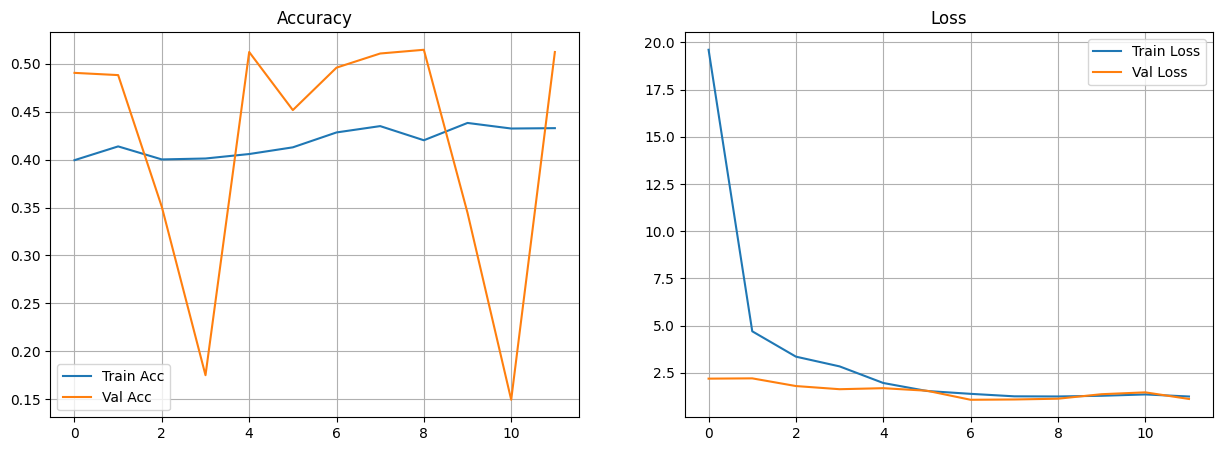

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os

# --- 해결책 적용 시작 ---

# 1) Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 2) Drive의 '폴더'를 Colab 로컬 저장소로 복사 (속도 향상)
# 수천 개의 파일을 직접 읽는 Drive 병목 현상을 해결합니다.
SOURCE_DIR_ON_DRIVE = '/content/drive/MyDrive/인공지능 튜플/OriginalDataset'
DEST_DIR_LOCAL = '/content/OriginalDataset' # 로컬에 복사될 경로

print("데이터 폴더를 로컬로 복사합니다. 파일 수에 따라 시간이 걸릴 수 있습니다...")
# !cp -r {SOURCE} {DESTINATION} : 폴더를 재귀적으로 복사하는 셸 명령어
!cp -r "{SOURCE_DIR_ON_DRIVE}" "{DEST_DIR_LOCAL}"
print("폴더 복사 완료!")

# 3) 데이터 경로를 '빠른 로컬 경로'로 설정
DATA_DIR = DEST_DIR_LOCAL

# --- 해결책 적용 끝 ---


# 2) 데이터셋 로드 (train/val 분리)
# ----------------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.2
SEED = 123

train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset='training',
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset='validation',
)

class_names = train_dataset.class_names
NUM_CLASSES = len(class_names)
print("클래스:", class_names)

# 성능 최적화
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset   = val_dataset.prefetch(AUTOTUNE)

# ----------------------------
# 3) 모델 구성요소 (이하 모든 코드는 이전과 동일)
# ----------------------------
class PositionalEmbedding(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.pos_emb = None

    def build(self, input_shape):
        tokens = int(input_shape[-2])
        dim = int(input_shape[-1])
        self.pos_emb = self.add_weight(
            name="pos_emb",
            shape=(tokens, dim),
            initializer=keras.initializers.RandomNormal(stddev=0.02),
            trainable=True,
        )

    def call(self, x):
        return x + self.pos_emb

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, attn_drop=0.0, drop=0.0, **kwargs):
        super().__init__(**kwargs)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=attn_drop)
        self.drop1 = layers.Dropout(drop)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = keras.Sequential([
            layers.Dense(int(embed_dim * mlp_ratio), activation=tf.nn.gelu),
            layers.Dropout(drop),
            layers.Dense(embed_dim),
            layers.Dropout(drop),
        ])

    def call(self, x, training=False):
        h = self.norm1(x)
        h = self.mha(h, h, training=training)
        x = x + self.drop1(h, training=training)
        h = self.norm2(x)
        h = self.mlp(h, training=training)
        x = x + h
        return x

# ----------------------------
# 4) CNN-ViT 하이브리드 모델
# ----------------------------
def build_cnn_vit_model(input_shape, num_classes, num_blocks=4, num_heads=4, drop=0.1):
    inputs = layers.Input(shape=input_shape)
    aug = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ], name="augmentation")(inputs)
    backbone = keras.applications.efficientnet_v2.EfficientNetV2B0(
        include_top=False, weights="imagenet", input_tensor=aug
    )
    backbone.trainable = True
    x = backbone.output
    C = x.shape[-1]
    x = layers.Reshape((-1, C))(x)
    x = PositionalEmbedding()(x)
    for _ in range(num_blocks):
        x = TransformerEncoder(embed_dim=int(C), num_heads=num_heads, mlp_ratio=4.0, drop=drop)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

model = build_cnn_vit_model(input_shape=IMG_SIZE + (3,), num_classes=NUM_CLASSES)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

# ----------------------------
# 5) 학습
# ----------------------------
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

EPOCHS = 50 # 최대 50 epoch
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping] # 조기 종료 추가
)

# ----------------------------
# 6) 플롯
# ----------------------------
acc = history.history['accuracy'];     val_acc = history.history['val_accuracy']
loss = history.history['loss'];       val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Train Acc'); plt.plot(epochs_range, val_acc, label='Val Acc')
plt.legend(); plt.title('Accuracy'); plt.grid(True)
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Train Loss'); plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(); plt.title('Loss'); plt.grid(True)
plt.show()

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os

# --- 해결책 적용 시작 (1/2): 필요한 라이브러리 임포트 ---
from sklearn.utils import class_weight
# --- 해결책 적용 끝 (1/2) ---


# 1) Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 2) Drive의 '폴더'를 Colab 로컬 저장소로 복사 (속도 향상)
SOURCE_DIR_ON_DRIVE = '/content/drive/MyDrive/인공지능 튜플/OriginalDataset'
DEST_DIR_LOCAL = '/content/OriginalDataset' # 로컬에 복사될 경로

print("데이터 폴더를 로컬로 복사합니다. 파일 수에 따라 시간이 걸릴 수 있습니다...")
!cp -r "{SOURCE_DIR_ON_DRIVE}" "{DEST_DIR_LOCAL}"
print("폴더 복사 완료!")

# 3) 데이터 경로를 '빠른 로컬 경로'로 설정
DATA_DIR = DEST_DIR_LOCAL


# 2) 데이터셋 로드 (train/val 분리)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.2
SEED = 123

train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset='training',
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset='validation',
)

class_names = train_dataset.class_names
NUM_CLASSES = len(class_names)
print("클래스:", class_names)

# 성능 최적화
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset   = val_dataset.prefetch(AUTOTUNE)


# --- 해결책 적용 시작 (2/2): 클래스 가중치 계산 ---
# 데이터 불균형 문제를 해결하기 위해, 수가 적은 클래스에 더 높은 가중치를 부여합니다.
print("클래스 가중치 계산을 시작합니다...")
# 데이터셋을 순회하며 모든 라벨을 수집합니다.
train_labels = []
for _, labels in train_dataset.unbatch():
    train_labels.append(labels.numpy())

# scikit-learn을 사용하여 클래스 가중치를 계산합니다.
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
# Keras가 요구하는 딕셔너리 형태로 변환합니다. (e.g., {0: 1.2, 1: 15.3, ...})
class_weights_dict = dict(enumerate(class_weights))
print("계산된 클래스 가중치:", class_weights_dict)
# --- 해결책 적용 끝 (2/2) ---


# 3) 모델 구성요소 (이하 모든 코드는 이전과 동일)
class PositionalEmbedding(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.pos_emb = None

    def build(self, input_shape):
        tokens = int(input_shape[-2])
        dim = int(input_shape[-1])
        self.pos_emb = self.add_weight(
            name="pos_emb", shape=(tokens, dim),
            initializer=keras.initializers.RandomNormal(stddev=0.02), trainable=True,
        )

    def call(self, x):
        return x + self.pos_emb

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, attn_drop=0.0, drop=0.0, **kwargs):
        super().__init__(**kwargs)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=attn_drop)
        self.drop1 = layers.Dropout(drop)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = keras.Sequential([
            layers.Dense(int(embed_dim * mlp_ratio), activation=tf.nn.gelu),
            layers.Dropout(drop),
            layers.Dense(embed_dim),
            layers.Dropout(drop),
        ])

    def call(self, x, training=False):
        h = self.norm1(x)
        h = self.mha(h, h, training=training)
        x = x + self.drop1(h, training=training)
        h = self.norm2(x)
        h = self.mlp(h, training=training)
        x = x + h
        return x

# 4) CNN-ViT 하이브리드 모델
def build_cnn_vit_model(input_shape, num_classes, num_blocks=4, num_heads=4, drop=0.1):
    inputs = layers.Input(shape=input_shape)
    aug = keras.Sequential([
        layers.RandomFlip("horizontal"), layers.RandomRotation(0.1), layers.RandomZoom(0.1),
    ], name="augmentation")(inputs)
    backbone = keras.applications.efficientnet_v2.EfficientNetV2B0(
        include_top=False, weights="imagenet", input_tensor=aug
    )
    backbone.trainable = True
    x = backbone.output
    C = x.shape[-1]
    x = layers.Reshape((-1, C))(x)
    x = PositionalEmbedding()(x)
    for _ in range(num_blocks):
        x = TransformerEncoder(embed_dim=int(C), num_heads=num_heads, mlp_ratio=4.0, drop=drop)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

model = build_cnn_vit_model(input_shape=IMG_SIZE + (3,), num_classes=NUM_CLASSES)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

# 5) 학습
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

EPOCHS = 50
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    class_weight=class_weights_dict # <- 가중치 적용
)

# 6) 플롯
acc = history.history['accuracy'];     val_acc = history.history['val_accuracy']
loss = history.history['loss'];       val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Train Acc'); plt.plot(epochs_range, val_acc, label='Val Acc')
plt.legend(); plt.title('Accuracy'); plt.grid(True)
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Train Loss'); plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(); plt.title('Loss'); plt.grid(True)
plt.show()

Mounted at /content/drive
데이터 폴더를 로컬로 복사합니다. 파일 수에 따라 시간이 걸릴 수 있습니다...
폴더 복사 완료!
Found 6430 files belonging to 4 classes.
Using 5144 files for training.
Found 6430 files belonging to 4 classes.
Using 1286 files for validation.
클래스: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
클래스 가중치 계산을 시작합니다...
계산된 클래스 가중치: {0: np.float64(1.773793103448276), 1: np.float64(25.215686274509803), 2: np.float64(0.5041160329282635), 3: np.float64(0.7077600440286186)}
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ augmentation[0][… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c

 Total params: 84,696,916 (323.09 MB)

 Trainable params: 84,636,308 (322.86 MB)

 Non-trainable params: 60,608 (236.75 KB)

Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 186s 744ms/step - accuracy: 0.2839 - loss: 68.6360 - val_accuracy: 0.3453 - val_loss: 51.0555
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 117s 726ms/step - accuracy: 0.2193 - loss: 57.1342 - val_accuracy: 0.1890 - val_loss: 9.9854
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 117s 729ms/step - accuracy: 0.2642 - loss: 33.6408 - val_accuracy: 0.3110 - val_loss: 13.5877
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 142s 728ms/step - accuracy: 0.2482 - loss: 21.2825 - val_accuracy: 0.1376 - val_loss: 16.0792
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 117s 726ms/step - accuracy: 0.2413 - loss: 31.6657 - val_accuracy: 0.3250 - val_loss: 15.9456
Epoch 6/50
138/161 ━━━━━━━━━━━━━━━━━━━━ 15s 663ms/step - accuracy: 0.2527 - loss: 33.6745

KeyboardInterrupt: 

[DATA_DIR] /content/OriginalDataset
Found 6430 files belonging to 4 classes.
Using 5144 files for training.
Found 6430 files belonging to 4 classes.
Using 1286 files for validation.
[classes] ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

[One-batch Overfit Test] 64장 과적합 시도 (1 epoch, steps=60)
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 42ms/step - accuracy: 0.4345 - loss: 1.1691

=> 결과 해석: 여기서 accuracy가 빠르게 0.9~1.0 근처로 오르면 파이프라인 정상입니다.
   그렇지 않다면 전처리/경로/라벨 불일치 가능성이 큽니다.

[Baseline] EfficientNetV2B0 + GAP + Dense (5 epochs)
Epoch 1/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 75s 301ms/step - accuracy: 0.4627 - loss: 1.0870 - val_accuracy: 0.5124 - val_loss: 1.0528
Epoch 2/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.4866 - loss: 1.0578 - val_accuracy: 0.5124 - val_loss: 1.0300
Epoch 3/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.4863 - loss: 1.0492 - val_accuracy: 0.5124 - val_loss: 1.0297
Epoch 4/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.491

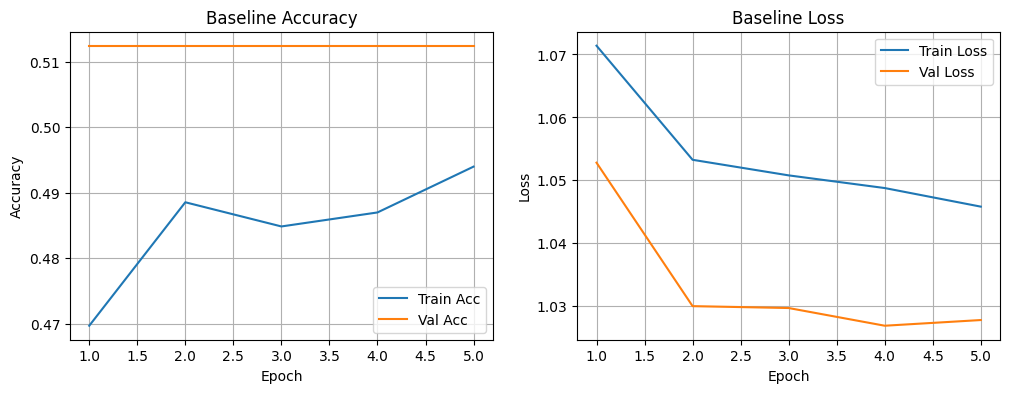


[Summary] One-batch acc ≈ 0.463  |  Baseline Val acc @5ep ≈ 0.512
 - One-batch acc가 낮으면: 경로/정규화/라벨 매핑부터 의심
 - Baseline Val acc가 0.6~0.8 근방으로 오르면 하이브리드/ViT 미세조정으로 넘어가도 안전


In [2]:
# ============================================
# Quick Sanity Checks (Colab / TensorFlow-Keras)
# 1) One-batch overfit test
# 2) Baseline EfficientNetV2B0 (5 epochs)
# ============================================
import os, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# ---- 0) 경로 설정 ----
# 이미 /content/OriginalDataset 로 복사해두었다면 그대로 사용.
# 아니라면 아래 Fallback 경로가 있으면 자동 선택.
DATA_DIR = '/content/OriginalDataset'
if not os.path.isdir(DATA_DIR):
    fallback = '/content/drive/MyDrive/인공지능 튜플/OriginalDataset'
    assert os.path.isdir(fallback), f"데이터 폴더를 찾지 못했습니다: {DATA_DIR} 또는 {fallback}"
    DATA_DIR = fallback
print("[DATA_DIR]", DATA_DIR)

IMG_SIZE = (224, 224)
BATCH    = 32
VAL_SPLIT= 0.2
SEED     = 123

# ---- 1) 데이터 로드(train/val) ----
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    shuffle=True, seed=SEED, validation_split=VAL_SPLIT, subset='training'
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    shuffle=True, seed=SEED, validation_split=VAL_SPLIT, subset='validation'
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("[classes]", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)

# ---- 2) 모델 빌더(베이스라인) ----
def build_baseline(input_shape=(224,224,3), num_classes=4, train_backbone=False):
    inp = layers.Input(input_shape)
    x = layers.Rescaling(1./255.)(inp)  # 스케일 고정
    backbone = keras.applications.efficientnet_v2.EfficientNetV2B0(
        include_top=False, weights='imagenet'
    )
    x = backbone(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='gelu')(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inp, out)
    backbone.trainable = train_backbone
    return model

# =========================================================
# A) One-batch overfit test (전처리/라벨/경로 무결성 체크)
# =========================================================
N = 64  # 한 번에 학습할 샘플 수
small_train = train_ds.unbatch().take(N).batch(min(BATCH, N)).repeat()

modelA = build_baseline(input_shape=IMG_SIZE+(3,), num_classes=num_classes)
modelA.compile(optimizer=keras.optimizers.Adam(1e-3),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

print("\n[One-batch Overfit Test] 64장 과적합 시도 (1 epoch, steps=60)")
histA = modelA.fit(small_train, steps_per_epoch=60, epochs=1, verbose=1)

print("\n=> 결과 해석: 여기서 accuracy가 빠르게 0.9~1.0 근처로 오르면 파이프라인 정상입니다.")
print("   그렇지 않다면 전처리/경로/라벨 불일치 가능성이 큽니다.\n")

# =========================================================
# B) Baseline Full Training (5 epochs)
# =========================================================
modelB = build_baseline(input_shape=IMG_SIZE+(3,), num_classes=num_classes)
modelB.compile(optimizer=keras.optimizers.Adam(1e-3),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

print("[Baseline] EfficientNetV2B0 + GAP + Dense (5 epochs)")
histB = modelB.fit(train_ds, validation_data=val_ds, epochs=5, verbose=1)

import matplotlib.pyplot as plt
epochs = range(1, len(histB.history['loss'])+1)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, histB.history['accuracy'], label='Train Acc')
plt.plot(epochs, histB.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Baseline Accuracy"); plt.legend(); plt.grid(True)
plt.subplot(1,2,2)
plt.plot(epochs, histB.history['loss'], label='Train Loss')
plt.plot(epochs, histB.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Baseline Loss"); plt.legend(); plt.grid(True)
plt.show()

# 간단한 판정 가이드라인 출력
ta = histA.history['accuracy'][-1] if 'accuracy' in histA.history else None
vb = histB.history['val_accuracy'][-1]
print(f"\n[Summary] One-batch acc ≈ {ta:.3f}  |  Baseline Val acc @5ep ≈ {vb:.3f}")
print(" - One-batch acc가 낮으면: 경로/정규화/라벨 매핑부터 의심")
print(" - Baseline Val acc가 0.6~0.8 근방으로 오르면 하이브리드/ViT 미세조정으로 넘어가도 안전")


Found 6430 files belonging to 4 classes.
Using 5144 files for training.
Found 6430 files belonging to 4 classes.
Using 1286 files for validation.

[Overfit] 64장에 대해 백본 포함 학습 (steps=80, epochs=2)
Epoch 1/2
80/80 ━━━━━━━━━━━━━━━━━━━━ 102s 134ms/step - accuracy: 0.7075 - loss: 0.6847
Epoch 2/2
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9542 - loss: 0.1334
=> 여기서 acc가 0.9~1.0 근처로 오르면 파이프라인 정상.

Epoch 1/3
161/161 ━━━━━━━━━━━━━━━━━━━━ 57s 191ms/step - accuracy: 0.4559 - loss: 1.0936 - val_accuracy: 0.3445 - val_loss: 1.0706
Epoch 2/3
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.4755 - loss: 1.0537 - val_accuracy: 0.5124 - val_loss: 1.0267
Epoch 3/3
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.4934 - loss: 1.0489 - val_accuracy: 0.5124 - val_loss: 1.0285
Epoch 1/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 167s 504ms/step - accuracy: 0.1303 - loss: 4.5087 - val_accuracy: 0.5124 - val_loss: 1.0371 - learning_rate: 1.0000e-05
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 140

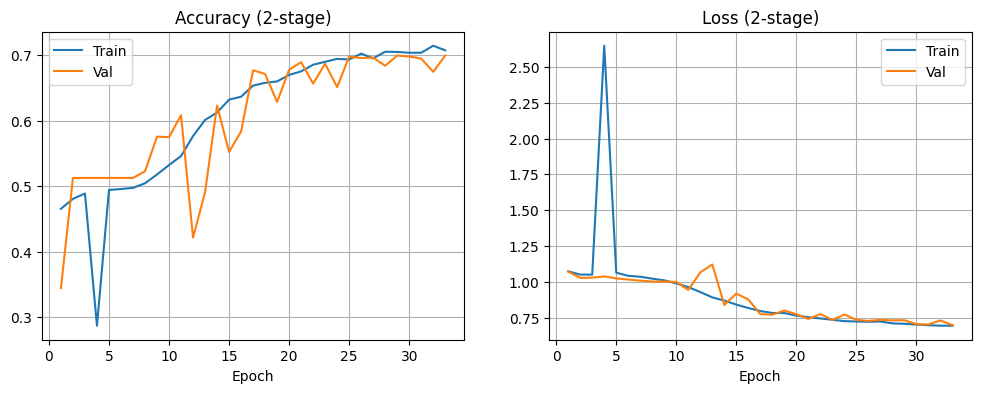

In [3]:
# ============================================
# Fix: backbone도 학습하도록 overfit test + 2-stage finetune
# ============================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os, matplotlib.pyplot as plt

# ---- 데이터 준비 (네가 이미 만든 train_ds/val_ds 재사용 권장) ----
DATA_DIR = '/content/OriginalDataset'
IMG_SIZE = (224,224); BATCH=32; VAL_SPLIT=0.2; SEED=123

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    shuffle=True, seed=SEED, validation_split=VAL_SPLIT, subset='training'
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    shuffle=True, seed=SEED, validation_split=VAL_SPLIT, subset='validation'
)

class_names = train_ds.class_names; num_classes = len(class_names)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE); val_ds = val_ds.prefetch(AUTOTUNE)

# ---- 모델 빌더 (Rescaling + EffNetV2B0) ----
def build_baseline(input_shape=(224,224,3), num_classes=4, train_backbone=True):
    inp = layers.Input(input_shape)
    x = layers.Rescaling(1./255.)(inp)             # (중요) 입력 스케일 고정
    backbone = keras.applications.efficientnet_v2.EfficientNetV2B0(
        include_top=False, weights='imagenet'
    )
    # 핵심: training=True로 호출하고, trainable 플래그도 켬
    x = backbone(x, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='gelu')(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inp, out)
    backbone.trainable = train_backbone
    return model, backbone

# =========================================================
# 1) One-batch overfit (백본도 학습)
# =========================================================
N = 64
small = train_ds.unbatch().take(N).batch(min(BATCH,N)).repeat()
modelA, bbA = build_baseline(IMG_SIZE+(3,), num_classes, train_backbone=True)
modelA.compile(optimizer=keras.optimizers.Adam(1e-3),
               loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("\n[Overfit] 64장에 대해 백본 포함 학습 (steps=80, epochs=2)")
histA = modelA.fit(small, steps_per_epoch=80, epochs=2, verbose=1)
print("=> 여기서 acc가 0.9~1.0 근처로 오르면 파이프라인 정상.\n")

# =========================================================
# 2) 두 단계 파인튜닝 (전체 데이터)
#    단계1: 헤드만 3ep  / 단계2: 백본까지 전부 20~40ep
# =========================================================
# 단계1
modelB, bbB = build_baseline(IMG_SIZE+(3,), num_classes, train_backbone=False)  # freeze
modelB.compile(optimizer=keras.optimizers.Adam(1e-3),
               loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist1 = modelB.fit(train_ds, validation_data=val_ds, epochs=3, verbose=1)

# 단계2
bbB.trainable = True
modelB.compile(optimizer=keras.optimizers.Adam(1e-5),
               loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cb_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
cb_plateau = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
hist2 = modelB.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[cb_early, cb_plateau], verbose=1)

# 플롯
acc = hist1.history['accuracy'] + hist2.history['accuracy']
val_acc = hist1.history['val_accuracy'] + hist2.history['val_accuracy']
loss = hist1.history['loss'] + hist2.history['loss']
val_loss = hist1.history['val_loss'] + hist2.history['val_loss']

import numpy as np
epochs = np.arange(1, len(val_loss)+1)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(epochs, acc, label='Train'); plt.plot(epochs, val_acc, label='Val')
plt.title('Accuracy (2-stage)'); plt.xlabel('Epoch'); plt.grid(True); plt.legend()
plt.subplot(1,2,2); plt.plot(epochs, loss, label='Train'); plt.plot(epochs, val_loss, label='Val')
plt.title('Loss (2-stage)'); plt.xlabel('Epoch'); plt.grid(True); plt.legend()
plt.show()


Found 6430 files belonging to 4 classes.
Using 5144 files for training.
Found 6430 files belonging to 4 classes.
Using 1286 files for validation.
[classes] ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Epoch 1/8
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.3452 - loss: 1.3463
Epoch 1: val_accuracy improved from -inf to 0.83670, saving model to /content/drive/MyDrive/인공지능 튜플/proj_pr/out/best_res288.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 288s 750ms/step - accuracy: 0.3456 - loss: 1.3460 - val_accuracy: 0.8367 - val_loss: 1.1620
Epoch 2/8
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.5081 - loss: 1.1893
Epoch 2: val_accuracy did not improve from 0.83670
161/161 ━━━━━━━━━━━━━━━━━━━━ 32s 200ms/step - accuracy: 0.5082 - loss: 1.1892 - val_accuracy: 0.2628 - val_loss: 1.1577
Epoch 3/8
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.5430 - loss: 1.1165
Epoch 3: val_accuracy did not improve from 0.83670
161/161 ━━━━━━━━━━━━━━━━━━━━ 31s 194ms/step - accuracy: 0.5430 - loss: 1.1164 - val_accuracy: 0.6579 - val_loss: 1.0868
Epoch 4/8
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.5642 - loss: 1.0661
Epoch 4: val_accuracy did not improve from 0.83670
161/161 ━━━━━━━━━━━━━━━━━━━━ 32s 198ms/step - accuracy: 0.5642 - loss: 1.0661 - val_accuracy: 0.6143 - val_loss: 1.0572
Epoch 5/8
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.5783 - loss: 1.0452
Epoch 5: val_accur

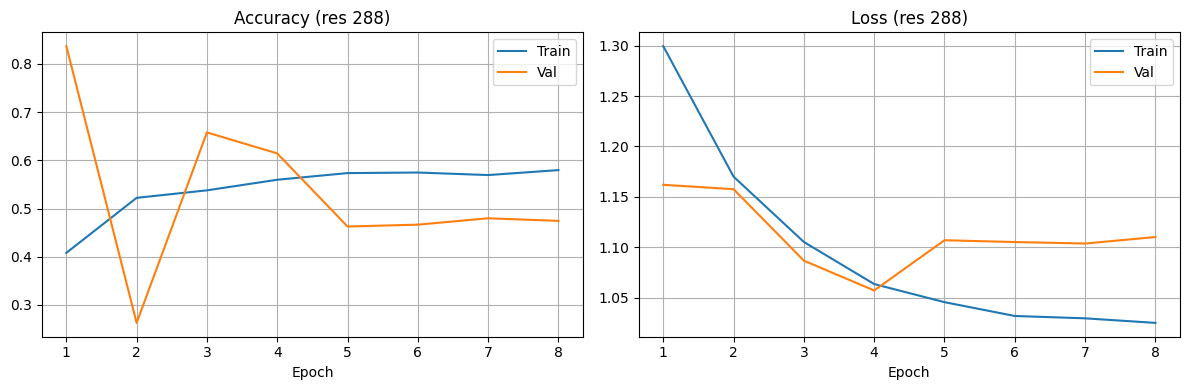

ValueError: Number of classes, 3, does not match size of target_names, 4. Try specifying the labels parameter

In [6]:
# ======================================================
# Resolution bump (224→288) fine-tune with ONE-HOT labels
# - CategoricalCrossentropy(label_smoothing=0.1)
# - AdamW + Cosine decay
# - Validation report & confusion matrix
# - Simple TTA (original + horizontal flip)
# ======================================================
import os, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ------------------------
# Paths & config
# ------------------------
BASE = '/content/drive/MyDrive/인공지능 튜플'
OUT  = f'{BASE}/proj_pr/out'
BEST_224 = f'{OUT}/best_effnetv2b0.h5'      # 224단계에서 저장해둔 가중치(있으면 로드)
os.makedirs(OUT, exist_ok=True)

DATA_DIR = '/content/OriginalDataset'        # 이미 로컬로 복사해둔 폴더 사용
IMG_SIZE = (288, 288)                        # ← bump
BATCH    = 32
VAL_SPLIT= 0.2
SEED     = 123

# ------------------------
# Datasets (train/val)
# ------------------------
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    shuffle=True, seed=SEED, validation_split=VAL_SPLIT, subset='training'
)
val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    shuffle=False, seed=SEED, validation_split=VAL_SPLIT, subset='validation'
)

class_names = train_ds_raw.class_names
num_classes = len(class_names)
print("[classes]", class_names)

AUTOTUNE = tf.data.AUTOTUNE

# ---- (옵션 B) one-hot 라벨로 변환
def to_one_hot(x, y):
    return x, tf.one_hot(y, num_classes)

train_ds = train_ds_raw.map(to_one_hot, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds   = val_ds_raw.map(to_one_hot,   num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

# ------------------------
# Model (EffNetV2B0 + GAP)
# ------------------------
def build_model(input_shape, num_classes, train_backbone=True):
    inp = layers.Input(shape=input_shape)
    x = layers.Rescaling(1./255.)(inp)
    backbone = keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False, weights='imagenet')
    x = backbone(x, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='gelu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inp, out)
    backbone.trainable = train_backbone
    return model

model = build_model(IMG_SIZE + (3,), num_classes, train_backbone=True)

# 224단계 가중치가 있으면 로드(레이어 이름 일치 부분만)
if os.path.isfile(BEST_224):
    model.load_weights(BEST_224, by_name=True, skip_mismatch=True)
    print("[✓] Loaded previous weights:", BEST_224)

# ------------------------
# Optimizer / schedule
# ------------------------
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
sched = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=5e-6, decay_steps=8 * max(1, steps_per_epoch), alpha=1e-2
)
opt = keras.optimizers.AdamW(learning_rate=sched, weight_decay=1e-4)

# ------------------------
# Compile with label smoothing (one-hot)
# ------------------------
model.compile(
    optimizer=opt,
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']  # one-hot -> categorical accuracy
)

ckpt = keras.callbacks.ModelCheckpoint(
    f'{OUT}/best_res288.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1
)

# ------------------------
# Train (8 epochs fine-tune)
# ------------------------
EPOCHS = 8
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[ckpt], verbose=1)

# ------------------------
# Curves
# ------------------------
epochs = range(1, len(history.history['loss'])+1)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, history.history['accuracy'], label='Train'); plt.plot(epochs, history.history['val_accuracy'], label='Val')
plt.title('Accuracy (res 288)'); plt.xlabel('Epoch'); plt.legend(); plt.grid(True)
plt.subplot(1,2,2)
plt.plot(epochs, history.history['loss'], label='Train'); plt.plot(epochs, history.history['val_loss'], label='Val')
plt.title('Loss (res 288)'); plt.xlabel('Epoch'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.savefig(f'{OUT}/training_curves_res288.png', dpi=200); plt.show()

# ------------------------
# Validation report & confusion matrix (one-hot → argmax)
# ------------------------
y_true, y_pred = [], []
for x, y in val_ds:
    p = model.predict(x, verbose=0)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(p, axis=1))

rep = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("\n[Validation report]\n", rep)
with open(f'{OUT}/val_report_res288.txt', 'w') as f:
    f.write(rep)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5.6,4.8))
plt.imshow(cm, cmap='Blues'); plt.title('Confusion Matrix (Val, 288)'); plt.colorbar()
ticks = np.arange(num_classes)
plt.xticks(ticks, class_names, rotation=45, ha='right'); plt.yticks(ticks, class_names)
for i in range(num_classes):
    for j in range(num_classes):
        v = cm[i, j]; c = 'white' if v > cm.max()/2 else 'black'
        plt.text(j, i, str(v), ha='center', va='center', color=c, fontsize=9)
plt.tight_layout(); plt.savefig(f'{OUT}/confmat_val_res288.png', dpi=220); plt.show()

# ------------------------
# Simple TTA (original + horizontal flip)
# ------------------------
def eval_tta(model, ds):
    y_true, y_pred = [], []
    for x, y in ds:
        p1 = model.predict(x, verbose=0)
        p2 = model.predict(tf.image.flip_left_right(x), verbose=0)
        p  = (p1 + p2) / 2.0
        y_true.extend(np.argmax(y.numpy(), axis=1))
        y_pred.extend(np.argmax(p, axis=1))
    return np.array(y_true), np.array(y_pred)

y_tta, pred_tta = eval_tta(model, val_ds)
print("\n[TTA report]\n", classification_report(y_tta, pred_tta, target_names=class_names, digits=4))
with open(f'{OUT}/val_report_res288_tta.txt','w') as f:
    f.write(classification_report(y_tta, pred_tta, target_names=class_names, digits=4))

print("\nSaved artifacts in:", OUT)


Found 6430 files belonging to 4 classes.
Using 1286 files for validation.
[✓] loaded: /content/drive/MyDrive/인공지능 튜플/proj_pr/out/best_res288.h5
[VAL] acc=0.8367, loss=1.1337

[Validation report]
                  precision    recall  f1-score   support

    MildDemented     0.0000    0.0000    0.0000         0
ModerateDemented     0.0000    0.0000    0.0000         0
     NonDemented     0.0000    0.0000    0.0000         0
VeryMildDemented     1.0000    0.8367    0.9111      1286

        accuracy                         0.8367      1286
       macro avg     0.2500    0.2092    0.2278      1286
    weighted avg     1.0000    0.8367    0.9111      1286



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


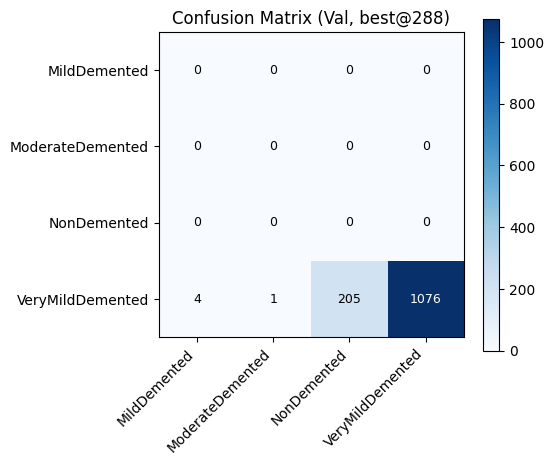

In [8]:
# ---- Evaluate best_res288.h5 properly (compile first) ----
import os, numpy as np, tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

BASE = '/content/drive/MyDrive/인공지능 튜플'
OUT  = f'{BASE}/proj_pr/out'
BEST = f'{OUT}/best_res288.h5'
DATA_DIR = '/content/OriginalDataset'
IMG_SIZE = (288, 288); BATCH = 32; VAL_SPLIT = 0.2; SEED = 123

# 1) val 데이터 로더 (one-hot 라벨)
val_raw = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    shuffle=False, seed=SEED, validation_split=VAL_SPLIT, subset='validation'
)
class_names = val_raw.class_names; C = len(class_names)
val_ds = val_raw.map(lambda x, y: (x, tf.one_hot(y, C)))

# 2) 모델 재구성 + 가중치 로드
def build_model(input_shape, num_classes):
    inp = keras.layers.Input(input_shape)
    x = keras.layers.Rescaling(1./255.)(inp)
    b = keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False, weights='imagenet')
    x = b(x, training=False)                          # 평가이므로 inference 모드
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(256, activation='gelu')(x)
    x = keras.layers.Dropout(0.3)(x)
    out = keras.layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inp, out)

model = build_model(IMG_SIZE + (3,), C)
model.load_weights(BEST)
print("[✓] loaded:", BEST)

# 3) 반드시 컴파일 후 evaluate
model.compile(
    optimizer='adam',  # 평가만 하므로 어떤 옵티마든 OK
    loss=keras.losses.CategoricalCrossentropy(),  # one-hot 라벨
    metrics=['accuracy']
)

loss, acc = model.evaluate(val_ds, verbose=0)
print(f"[VAL] acc={acc:.4f}, loss={loss:.4f}")

# 4) 분류 리포트 & 혼동행렬
y_true, y_pred = [], []
for x, y in val_ds:
    p = model.predict(x, verbose=0)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(p, axis=1))

print("\n[Validation report]")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5.6,4.8))
plt.imshow(cm, cmap='Blues'); plt.title('Confusion Matrix (Val, best@288)'); plt.colorbar()
ticks = np.arange(C); plt.xticks(ticks, class_names, rotation=45, ha='right'); plt.yticks(ticks, class_names)
for i in range(C):
    for j in range(C):
        v = cm[i, j]; c = 'white' if v > cm.max()/2 else 'black'
        plt.text(j, i, str(v), ha='center', va='center', color=c, fontsize=9)
plt.tight_layout(); plt.savefig(f'{OUT}/confmat_val_best_res288.png', dpi=220); plt.show()


In [9]:
import numpy as np, tensorflow as tf, os
DATA_DIR = '/content/OriginalDataset'
IMG_SIZE=(288,288); BATCH=32; SEED=123
val_raw = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    shuffle=False, seed=SEED, validation_split=0.2, subset='validation'
)
names = val_raw.class_names; C=len(names)
counts = np.zeros(C, dtype=int)
for _, y in val_raw:
    y = y.numpy()
    counts += np.bincount(y, minlength=C)
print("val 분포:", dict(zip(names, counts.tolist())))


Found 6430 files belonging to 4 classes.
Using 1286 files for validation.
val 분포: {'MildDemented': 0, 'ModerateDemented': 0, 'NonDemented': 0, 'VeryMildDemented': 1286}


In [10]:
# --- 계층 분할: /content/dataset_split/{train,val}/<class> (심볼릭 링크; 실패 시 복사) ---
import os, glob, random, shutil
SRC = '/content/OriginalDataset'
DST = '/content/dataset_split'
VAL_RATIO = 0.2
SEED = 123
random.seed(SEED)

def ensure(p): os.makedirs(p, exist_ok=True)
def safe_link(src, dst):
    try: os.symlink(src, dst)
    except OSError: shutil.copy2(src, dst)

classes = sorted([d for d in os.listdir(SRC) if os.path.isdir(os.path.join(SRC,d))])
if os.path.isdir(DST): shutil.rmtree(DST)
for split in ('train','val'):
    for c in classes: ensure(os.path.join(DST, split, c))

for c in classes:
    files = []
    for ext in ('*.png','*.jpg','*.jpeg','*.bmp'):
        files += glob.glob(os.path.join(SRC, c, ext))
    random.shuffle(files)
    n = len(files); n_val = int(round(n*VAL_RATIO))
    val_f, train_f = files[:n_val], files[n_val:]
    for fp in val_f:   safe_link(fp, os.path.join(DST, 'val',   c, os.path.basename(fp)))
    for fp in train_f: safe_link(fp, os.path.join(DST, 'train', c, os.path.basename(fp)))
print("계층 분할 완료 →", DST)


계층 분할 완료 → /content/dataset_split


Found 5144 files belonging to 4 classes.
Found 1286 files belonging to 4 classes.
[✓] loaded: /content/drive/MyDrive/인공지능 튜플/proj_pr/out/best_res288.h5
[VAL(stratified)] acc=0.4666, loss=1.2326

[Validation report (stratified)]
                  precision    recall  f1-score   support

    MildDemented     0.0000    0.0000    0.0000       179
ModerateDemented     0.0000    0.0000    0.0000        13
     NonDemented     0.6879    0.3536    0.4671       642
VeryMildDemented     0.3906    0.8252    0.5302       452

        accuracy                         0.4666      1286
       macro avg     0.2696    0.2947    0.2493      1286
    weighted avg     0.4807    0.4666    0.4195      1286



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


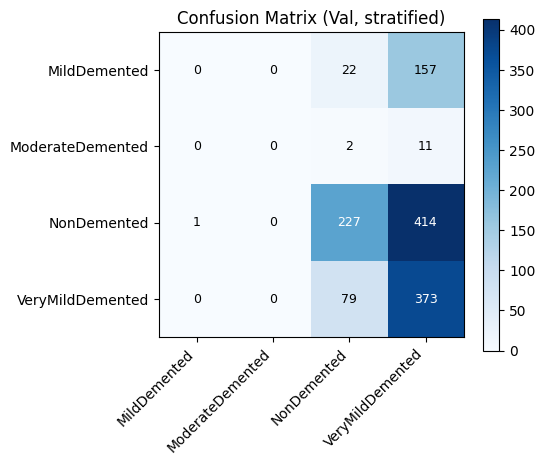

In [11]:
import numpy as np, tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt, os

BASE = '/content/drive/MyDrive/인공지능 튜플'
OUT  = f'{BASE}/proj_pr/out'
BEST = f'{OUT}/best_res288.h5'
SPLIT = '/content/dataset_split'
IMG_SIZE=(288,288); BATCH=32

train_raw = tf.keras.utils.image_dataset_from_directory(
    os.path.join(SPLIT,'train'), image_size=IMG_SIZE, batch_size=BATCH, shuffle=True)
val_raw   = tf.keras.utils.image_dataset_from_directory(
    os.path.join(SPLIT,'val'),   image_size=IMG_SIZE, batch_size=BATCH, shuffle=False)

names = train_raw.class_names; C=len(names)
to_oh = lambda x,y: (x, tf.one_hot(y, C))
train_ds = train_raw.map(to_oh)
val_ds   = val_raw.map(to_oh)

def build_model(input_shape, C):
    inp = keras.layers.Input(input_shape)
    x = keras.layers.Rescaling(1./255.)(inp)
    b = keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False, weights='imagenet')
    x = b(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(256, activation='gelu')(x)
    x = keras.layers.Dropout(0.3)(x)
    out = keras.layers.Dense(C, activation='softmax')(x)
    return keras.Model(inp, out)

model = build_model(IMG_SIZE+(3,), C)
model.load_weights(BEST); print("[✓] loaded:", BEST)
model.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# 재평가
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"[VAL(stratified)] acc={val_acc:.4f}, loss={val_loss:.4f}")

y_true, y_pred = [], []
for x, y in val_ds:
    p = model.predict(x, verbose=0)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(p, axis=1))
print("\n[Validation report (stratified)]")
print(classification_report(y_true, y_pred, target_names=names, digits=4))

# 혼동행렬
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5.6,4.8)); plt.imshow(cm, cmap='Blues'); plt.title('Confusion Matrix (Val, stratified)')
plt.colorbar(); ticks = np.arange(C); plt.xticks(ticks, names, rotation=45, ha='right'); plt.yticks(ticks, names)
for i in range(C):
    for j in range(C):
        v=cm[i,j]; c='white' if v>cm.max()/2 else 'black'
        plt.text(j,i,str(v),ha='center',va='center',color=c,fontsize=9)
plt.tight_layout(); plt.savefig(f'{OUT}/confmat_val_stratified.png', dpi=220); plt.show()


classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Found 1286 files belonging to 4 classes.
[✓] loaded prev: /content/drive/MyDrive/인공지능 튜플/proj_pr/out/best_res288.h5
Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/legacy/saving/legacy_h5_format.py:513: UserWarning: Skipping loading weights for layer #2 (named efficientnetv2-b0)due to mismatch in shape for weight block1a_project_conv/kernel. Weight expects shape (3, 3, 32, 16). Received saved weight with shape (32,)
  _set_weights(
/usr/local/lib/python3.12/dist-packages/keras/src/legacy/saving/legacy_h5_format.py:513: UserWarning: Skipping loading weights for layer #2 (named efficientnetv2-b0)due to mismatch in shape for weight block2a_expand_conv/kernel. Weight expects shape (3, 3, 16, 64). Received saved weight with shape (32,)
  _set_weights(
/usr/local/lib/python3.12/dist-packages/keras/src/legacy/saving/legacy_h5_format.py:513: UserWarning: Skipping loading weights for layer #2 (named efficientnetv2-b0)due to mismatch in shape for weight block2a_project_conv/kernel. Weight expects shape (1, 1, 64, 32). Received saved weight with shape (3, 3, 32, 16)
  _set_weights(
/usr/local/lib/python3.12/

300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.2504 - loss: nan
Epoch 1: val_accuracy improved from -inf to 0.34681, saving model to /content/drive/MyDrive/인공지능 튜플/proj_pr/out/best_balanced_focal.h5


300/300 ━━━━━━━━━━━━━━━━━━━━ 166s 227ms/step - accuracy: 0.2503 - loss: nan - val_accuracy: 0.3468 - val_loss: nan - learning_rate: 1.0000e-05
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.2662 - loss: nan
Epoch 2: val_accuracy did not improve from 0.34681

Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 145ms/step - accuracy: 0.2662 - loss: nan - val_accuracy: 0.3468 - val_loss: nan - learning_rate: 1.0000e-05
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.2519 - loss: nan
Epoch 3: val_accuracy did not improve from 0.34681
300/300 ━━━━━━━━━━━━━━━━━━━━ 42s 140ms/step - accuracy: 0.2519 - loss: nan - val_accuracy: 0.3468 - val_loss: nan - learning_rate: 5.0000e-06
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.2602 - loss: nan
Epoch 4: val_accuracy did not improve from 0.34681

Epoch 4: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
300/300 ━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


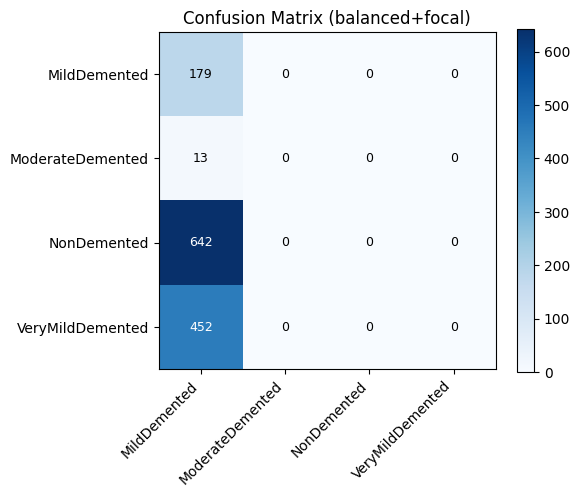

In [12]:
# =========================================================
# Balanced sampler + focal loss fine-tune (res=288)
# =========================================================
import os, glob, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

SPLIT = '/content/dataset_split'  # 이전 단계에서 만든 계층 분할 경로
OUT   = '/content/drive/MyDrive/인공지능 튜플/proj_pr/out'
BEST  = f'{OUT}/best_res288.h5'   # 직전 최선 가중치 (있으면 로드)
IMG_SIZE = (288,288); BATCH = 32
AUTOTUNE = tf.data.AUTOTUNE

# -------- 1) helper: 파일 리스트 → tf.data (unbatched) --------
def list_files_by_class(root):
    classes = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root,d))])
    paths = {c: sum([glob.glob(os.path.join(root, c, ext)) for ext in ('*.png','*.jpg','*.jpeg','*.bmp')], []) for c in classes}
    return classes, paths

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    return img, label

# -------- 2) train: 클래스 균형 샘플러 --------
classes, train_paths = list_files_by_class(os.path.join(SPLIT, 'train'))
C = len(classes)
print("classes:", classes)

per_class_ds = []
freq = []
for i, c in enumerate(classes):
    files = tf.constant(train_paths[c])
    labels = tf.fill([tf.shape(files)[0]], i)
    ds = tf.data.Dataset.from_tensor_slices((files, labels)).shuffle(4096, reshuffle_each_iteration=True)
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE).repeat()   # repeat로 소수 클래스 고갈 방지
    per_class_ds.append(ds)
    freq.append(len(train_paths[c]))

# 균등 가중치로 샘플링 → 배치/증강/one-hot/프리페치
balanced = tf.data.Dataset.sample_from_datasets(per_class_ds, weights=[1.0/C]*C, stop_on_empty_dataset=False)
def augment(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_contrast(x, 0.9, 1.1)
    x = tf.image.random_brightness(x, 0.05)
    return x, y

train_ds_bal = (balanced
                .map(augment, num_parallel_calls=AUTOTUNE)
                .map(lambda x,y: (x/255.0, tf.one_hot(y, C)), num_parallel_calls=AUTOTUNE)
                .batch(BATCH)
                .prefetch(AUTOTUNE))

# -------- 3) val: 기존 계층분할 val 사용(원-핫) --------
val_raw = tf.keras.utils.image_dataset_from_directory(
    os.path.join(SPLIT,'val'), image_size=IMG_SIZE, batch_size=BATCH, shuffle=False)
val_ds = val_raw.map(lambda x,y: (x/255.0, tf.one_hot(y, C))).prefetch(AUTOTUNE)

# -------- 4) 모델 구성 & 가중치 로드 --------
def build_model(input_shape, num_classes):
    inp = layers.Input(input_shape)
    x = inp
    b = keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False, weights='imagenet')
    x = b(x, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='gelu')(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)
    m = keras.Model(inp, out)
    # BN은 고정, 상단 절반은 학습
    for l in b.layers:
        if isinstance(l, layers.BatchNormalization): l.trainable = False
    return m

model = build_model(IMG_SIZE+(3,), C)
if os.path.isfile(BEST):
    model.load_weights(BEST, by_name=True, skip_mismatch=True)
    print("[✓] loaded prev:", BEST)

# -------- 5) α-Focal loss (one-hot) --------
freq = np.array(freq, dtype=np.float32)
alpha = (freq.sum()/freq) / ( (freq.sum()/freq).sum() )   # 빈도 역비례를 확률합=1로 정규화
alpha_tf = tf.constant(alpha, dtype=tf.float32)

def focal_loss(gamma=2.0, alpha_vec=None, label_smoothing=0.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        if label_smoothing > 0.0:
            K = tf.cast(tf.shape(y_true)[-1], tf.float32)
            y_true = y_true*(1.0-label_smoothing) + label_smoothing/K
        y_pred = tf.clip_by_value(y_pred, 1e-6, 1-1e-6)
        ce = -tf.reduce_sum(y_true*tf.math.log(y_pred), axis=-1)
        p_t = tf.reduce_sum(y_true*y_pred, axis=-1)
        fl = (1.0 - p_t)**gamma * ce
        if alpha_vec is not None:
            alpha_t = tf.reduce_sum(y_true*alpha_vec, axis=-1)
            fl = alpha_t * fl
        return tf.reduce_mean(fl)
    return loss

opt = keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4)
model.compile(optimizer=opt, loss=focal_loss(gamma=2.0, alpha_vec=alpha_tf, label_smoothing=0.0), metrics=['accuracy'])

ckpt = keras.callbacks.ModelCheckpoint(f'{OUT}/best_balanced_focal.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
early= keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
plate= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

EPOCHS = 15
hist = model.fit(train_ds_bal, validation_data=val_ds, epochs=EPOCHS, steps_per_epoch= max(300, C*100//BATCH),
                 callbacks=[ckpt, plate, early], verbose=1)

# -------- 6) 평가/리포트 --------
y_true, y_pred = [], []
for x, y in val_ds:
    p = model.predict(x, verbose=0)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(p, axis=1))

print("\n[Validation report (balanced+focal)]")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues'); plt.title('Confusion Matrix (balanced+focal)'); plt.colorbar()
ticks = np.arange(C); plt.xticks(ticks, classes, rotation=45, ha='right'); plt.yticks(ticks, classes)
for i in range(C):
    for j in range(C):
        v=cm[i,j]; c='white' if v>cm.max()/2 else 'black'
        plt.text(j,i,str(v),ha='center',va='center',color=c,fontsize=9)
plt.tight_layout(); plt.savefig(f'{OUT}/confmat_balanced_focal.png', dpi=220); plt.show()
